In [2]:
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
from common.trajectory_analysis import Trajectory


In [4]:
files = glob.glob("..//data1//*.txt")

lowpass_cutoff = 10 # Hz
dt             = 0.005   # s
pxtomm         = 1/10.8  # from tablet px to mm

A = np.array
data = []
for f in files:
    d = json.load(open(f))
    d["filename"] = f
    ts = [d["ts"][i] - d["ts"][0] for i in range(len(d["ts"]))]
    tx = A(d["tx"]) * pxtomm
    ty = A(d["ty"]) * pxtomm
    cx = A(d["cx"]) * pxtomm
    cy = A(d["cy"]) * pxtomm
    
    d["target"] = Trajectory(tx, ty, ts, dt=dt, cut = [4, 0.2])
    d["target"].calc_betas(orthogonal=True)
    
    d["cursor"] = Trajectory(cx, cy, ts, dt=dt, cut = [4, 0.2], smooth=lowpass_cutoff, filter_order=4)
    d["cursor"].calc_betas(orthogonal=True)
    
    data.append(d)
  

In [5]:
# Speeds indicated in the filename correspond to frequencies of fundamentals of target movement:
filename_speeds = [     3,    5,    7,    9,   11,   13,   15,   17,   19]
freqs           = [  0.27, 0.40, 0.54, 0.67, 0.81, 0.94, 1.07, 1.21, 1.34]  # Hz

for d in data:
    f = d["filename"]
    spi = f.find("speed")
    fn_speed = int(f[spi+5:spi+8])
    fri = filename_speeds.index(fn_speed)
    d["freq"] = freqs[fri]
    



In [6]:
colors = {
    "target": "#882255",
    "cursor": "#44AA99"
}

In [7]:
#avergae target speeds:
tvm = [44,   67,    91,  113,   135,  158,  180,  203,  227] ## in mm/s

In [8]:
#Figure 2A Participant example, slow and fast movement speed profiles

def contains_all(target_string, str_list):
    return all([x in target_string for x in str_list] )
    
slows = [ d for d in data if contains_all(d["filename"], ["speed 3",  "am2"])]
fasts = [ d for d in data if contains_all(d["filename"], ["speed 19", "agm2"])]

slows.sort(key=lambda x: x["target"].betaCV, reverse=True)
fasts.sort(key=lambda x: x["target"].betaCV, reverse=True)


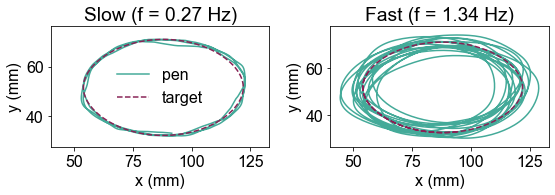

In [22]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 16}
matplotlib.rc('font', **font)


d =  slows[0]
c = d["cursor"]
t = d["target"]

fig, axs = plt.subplots(1,2, figsize=(8, 3))
ax = axs[0]
ax.set_title("Slow (f = 0.27 Hz)")
ax.plot(c.x, c.y, color=colors["cursor"], label="pen")
take = np.arange(int(1/dt), int(4.75/dt))
ax.plot(t.x[take], t.y[take], '--', color=colors["target"], label="target")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(frameon=False)

ax = axs[1]
ax.set_title("Fast (f = 1.34 Hz)")
d =  fasts[0]
c = d["cursor"]
t = d["target"]

ax.plot(c.x, c.y, color=colors["cursor"], label="pen")
take = np.arange(int(1/dt), int(2/dt))
ax.plot(t.x[take], t.y[take], '--', color=colors["target"], label="target")
ax.axis("equal")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())


plt.tight_layout()

plt.savefig("..//figures//Figure 2B.pdf", format="pdf", bbox_inches = "tight")
#plt.savefig("..//figures//Figure 2B.png", format="png", dpi=300)
plt.show()   

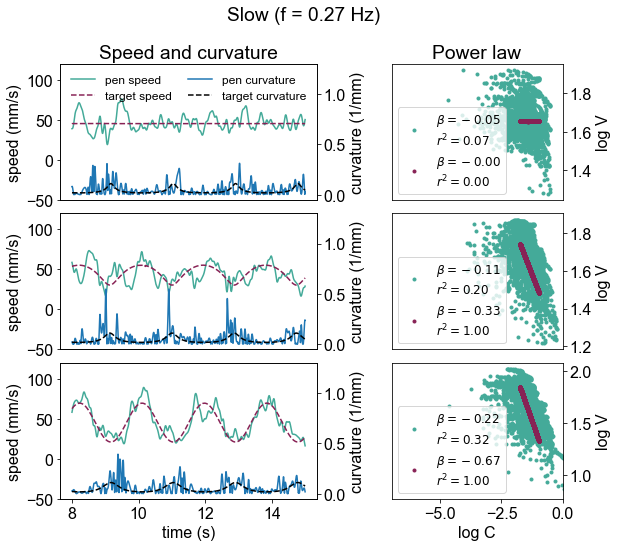

In [23]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(3,2, figsize=(9, 8), gridspec_kw={'width_ratios': [1.5, 1.0]})

for i in range(3):
    c = slows[i]["cursor"]
    t = slows[i]["target"]
    
    ax0 = axs[i, 0]
    ax1 = ax0.twinx()
    
    take = np.arange(int(4/dt), int(11/dt))
    ax0.plot(c.tf[take], c.V[take], color=colors["cursor"], label="pen speed")
    ax0.plot(t.tf[take], t.V[take], '--', color=colors["target"], label="target speed")
    ax0.set_ylabel("speed (mm/s)")
    ax1.plot(c.tf[take], c.C[take], label="pen curvature", color="tab:blue")
    ax1.plot(t.tf[take], t.C[take], "--", label="target curvature", color="black")
    
    ax1.set_ylabel("curvature (1/mm)")
    
    if i == 2: 
        ax0.set_xlabel("time (s)")
    else:
        ax0.set_xticks([])
    
    ax0.set_ylim(-50, 120)
    ax1.set_ylim(-0.05, 1.3)
    if i==0: 
        ax0.set_title("Speed and curvature")    
        ax0.legend(loc ="upper left", frameon=False,prop={'size':12})
        ax1.legend(loc ="upper right", frameon=False,prop={'size':12})
    
        
    ax = axs[i, 1]
    if i==0: ax.set_title("Power law")    
    ax.plot(c.logC, c.logV, '.', color=colors["cursor"], label=fr"$\beta = {c.betaCV:.2f}$" "\n"  fr"$r^2 = {c.r2CV:.2f}$" )    
    ax.plot(t.logC, t.logV, '.', color=colors["target"], label=fr"$\beta = {t.betaCV:.2f}$" "\n"  fr"$r^2 = {t.r2CV:.2f}$" )
    
    if i==2: 
        ax.set_xlabel("log C")
    else:
        ax.set_xticks([])
    ax.set_xlim(-7,0)
    ax.set_ylabel("log V")
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.legend(loc="lower left", prop={'size':12})
    
    
plt.suptitle("Slow (f = 0.27 Hz)")
plt.subplots_adjust(wspace=0.35, hspace=0.1)

#plt.savefig("..//figures//Figure 2C.pdf", format="pdf", bbox_inches = "tight")
plt.show()

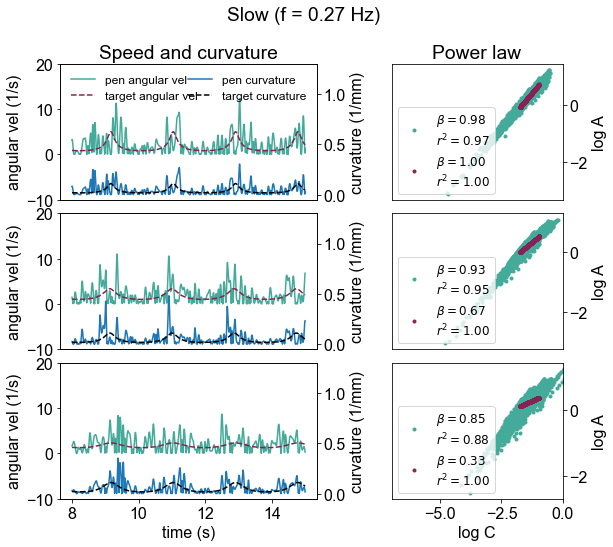

In [9]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(3,2, figsize=(9, 8), gridspec_kw={'width_ratios': [1.5, 1.0]})

for i in range(3):
    c = slows[i]["cursor"]
    t = slows[i]["target"]
    
    ax0 = axs[i, 0]
    ax1 = ax0.twinx()
    
    take = np.arange(int(4/dt), int(11/dt))
    ax0.plot(c.tf[take], c.A[take], color=colors["cursor"], label="pen angular vel")
    ax0.plot(t.tf[take], t.A[take], '--', color=colors["target"], label="target angular vel")
    ax0.set_ylabel("angular vel (1/s)")
    ax1.plot(c.tf[take], c.C[take], label="pen curvature", color="tab:blue")
    ax1.plot(t.tf[take], t.C[take], "--", label="target curvature", color="black")
    
    ax1.set_ylabel("curvature (1/mm)")
    
    if i == 2: 
        ax0.set_xlabel("time (s)")
    else:
        ax0.set_xticks([])
    
    ax0.set_ylim(-10, 20)
    ax1.set_ylim(-0.05, 1.3)
    if i==0: 
        ax0.set_title("Speed and curvature")    
        ax0.legend(loc ="upper left", frameon=False,prop={'size':12})
        ax1.legend(loc ="upper right", frameon=False,prop={'size':12})
    
        
    ax = axs[i, 1]
    if i==0: ax.set_title("Power law")    
    ax.plot(c.logC, c.logA, '.', color=colors["cursor"], label=fr"$\beta = {c.betaCA:.2f}$" "\n"  fr"$r^2 = {c.r2CA:.2f}$" )    
    ax.plot(t.logC, t.logA, '.', color=colors["target"], label=fr"$\beta = {t.betaCA:.2f}$" "\n"  fr"$r^2 = {t.r2CA:.2f}$" )
    
    if i==2: 
        ax.set_xlabel("log C")
    else:
        ax.set_xticks([])
    ax.set_xlim(-7,0)
    ax.set_ylabel("log A")
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.legend(loc="lower left", prop={'size':12})
    
    
plt.suptitle("Slow (f = 0.27 Hz)")
plt.subplots_adjust(wspace=0.35, hspace=0.1)

#plt.savefig("..//figures//Figure 2C.pdf", format="pdf", bbox_inches = "tight")
plt.show()

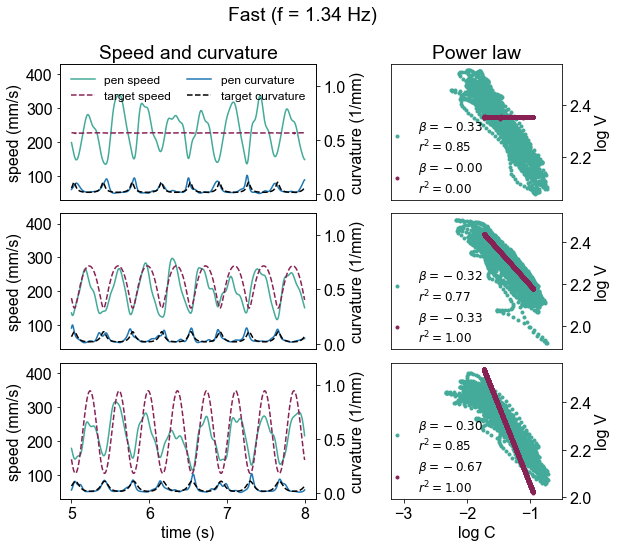

In [24]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(3,2, figsize=(9, 8), gridspec_kw={'width_ratios': [1.5, 1.0]})

for i in range(3):
    c = fasts[i]["cursor"]
    t = fasts[i]["target"]
    
    ax0 = axs[i, 0]
    ax1 = ax0.twinx()
    
    take = np.arange(int(1/dt), int(4/dt))
    ax0.plot(c.tf[take], c.V[take], color=colors["cursor"], label="pen speed")
    ax0.plot(t.tf[take], t.V[take], '--', color=colors["target"], label="target speed")
    ax0.set_ylabel("speed (mm/s)")
    ax1.plot(c.tf[take], c.C[take], label="pen curvature", color="tab:blue")
    ax1.plot(t.tf[take], t.C[take], "--", label="target curvature", color="black")
    
    ax1.set_ylabel("curvature (1/mm)")
    
    if i == 2: 
        ax0.set_xlabel("time (s)")
    else:
        ax0.set_xticks([])
    
    ax0.set_ylim(30, 430)
    ax1.set_ylim(-0.05, 1.2)
    if i==0: 
        ax0.set_title("Speed and curvature")    
        ax0.legend(loc ="upper left", frameon=False,prop={'size':12})
        ax1.legend(loc ="upper right", frameon=False,prop={'size':12})
    
        
    ax = axs[i, 1]
    if i==0: ax.set_title("Power law")    
    ax.plot(c.logC, c.logV, '.', color=colors["cursor"], label=fr"$\beta = {c.betaCV:.2f}$" "\n"  fr"$r^2 = {c.r2CV:.2f}$" )    
    ax.plot(t.logC, t.logV, '.', color=colors["target"], label=fr"$\beta = {t.betaCV:.2f}$" "\n"  fr"$r^2 = {t.r2CV:.2f}$" )
        
    if i==2: 
        ax.set_xlabel("log C")
    else:
        ax.set_xticks([])
    ax.set_xlim(-3.2,-0.5)
    ax.set_ylabel("log V")
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.legend(loc="lower left", frameon=False, prop={'size':12}, bbox_to_anchor=(-0.1, -0.05))
    
    
plt.subplots_adjust(wspace=0.35, hspace=0.1)

plt.suptitle("Fast (f = 1.34 Hz)")

#plt.savefig("..//figures//Figure 2D.pdf", format="pdf", bbox_inches = "tight")
plt.show()

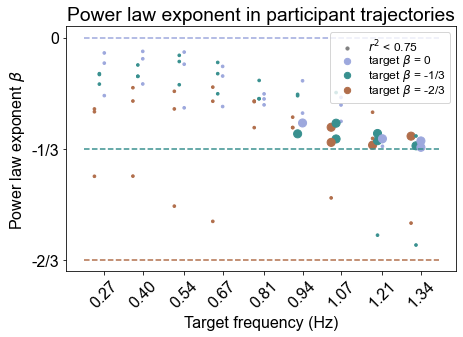

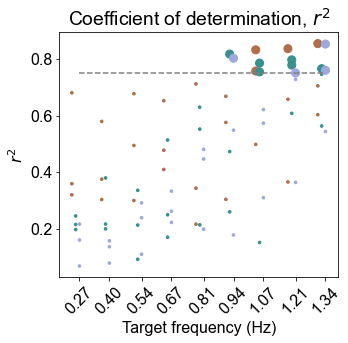

In [25]:
freqs_t  = [d["freq"] + d["target"].betaCV * 0.05 for d in data]

betas  = [d["cursor"].betaCV for d in data]
r2s    = [d["cursor"].r2CV   for d in data]

beta_colors = ["#9da8dd", "#38908f", "#b16e4B"]


tb     = [0 if "beta1.0" in d["filename"] else 1 if "beta0.6" in d["filename"] else 2 for d in data]
clrs     = [beta_colors[tb[i]] for i in range(len(r2s))]
sizes    = [65 if r2 >= 0.75 else 7 for r2 in r2s]

plt.figure(figsize=(7, 4.5))

plt.plot([0.2, 1.4], [0, 0], "--", color=beta_colors[0])
plt.plot([0.2, 1.4], [-1/3, -1/3], "--", color=beta_colors[1])
plt.plot([0.2, 1.4], [-2/3, -2/3], "--", color=beta_colors[2])

plt.yticks([0, -1/3, -2/3], ["0", "-1/3", "-2/3"])

plt.scatter(freqs_t, betas, c = clrs, s=sizes)

plt.scatter([], [], c = "gray", s=10, label=r"$r^2$ < 0.75")
plt.scatter([], [], c = beta_colors[0], s=40, label=r"target $\beta$ = 0")
plt.scatter([], [], c =  beta_colors[1], s=40, label=r"target $\beta$ = -1/3")
plt.scatter([], [], c =  beta_colors[2], s=40, label=r"target $\beta$ = -2/3")


plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"Power law exponent $\beta$")

plt.xticks(freqs, rotation = 45)
plt.legend(loc = "upper right", prop={"size":12}, labelspacing=-0.1)
plt.title("Power law exponent in participant trajectories")
#plt.savefig("..//figures//Figure 2 freq_participant.pdf", format="pdf",  bbox_inches = "tight")
plt.show()

plt.figure(figsize=(5, 4.5))

plt.title(r"Coefficient of determination, $r^2$")
plt.plot([0.27, 1.34], [0.75, 0.75], "--", color="gray")
plt.scatter(freqs_t, r2s, c=clrs, s= sizes)
plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"$r^2$")
plt.xticks(freqs, rotation = 45)
#plt.savefig("..//figures//Figure 2 Coefficient r2.pdf", format="pdf",  bbox_inches = "tight")
plt.show()

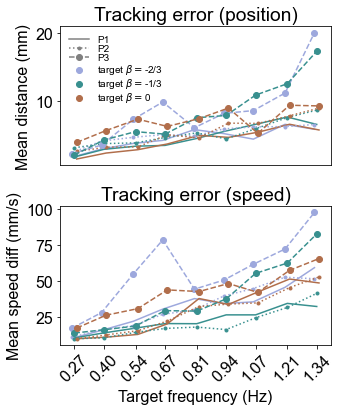

In [14]:
## Accuracy in tracking position and speed

def rmse(a, b): return (((a - b)**2).mean())**0.5



fig1, [ax1, ax2] = plt.subplots(2,1,figsize=(5, 6))

line_symbol = {"am2":"-", "agm2":".:", "sg2":"o--"}

for name in ["am2", "agm2", "sg2"]:    
    m066 = [d for d in data if name in d["filename"] and "beta0.66" in d["filename"]]
    m033 = [d for d in data if name in d["filename"] and "beta0.33" in d["filename"]]
    m100 = [d for d in data if name in d["filename"] and "beta1.0"  in d["filename"]]
    
    for l in m066, m033, m100:
        l.sort(key = lambda x: x["freq"])
        
    for i, m in enumerate([m033, m066, m100]):
        speeds  = [d["cursor"].V.mean() for d in m]
        freqs_t = np.array([d["freq"] for d in m])
        color   = beta_colors[i]

        fits_distance  = [np.mean(np.sqrt((d["target"].x-d["cursor"].x)**2 + (d["target"].y - d["cursor"].y)**2)) for d in m]
        ax1.plot(freqs_t + 0.01*(i-1), fits_distance, line_symbol[name], color=color)
        
        fits_speed  = [rmse(d["target"].V, d["cursor"].V) for d in m]
        ax2.plot(freqs_t + 0.01*(i-1), fits_speed, line_symbol[name], color=color)

for i in range(3):
    for ax in [ax1]:
        ax.scatter([],[], color=beta_colors[i], label=fr"target $\beta=${['-2/3', '-1/3', '0'][i]}")

for i in range(3):
    for ax in [ax1]:
        ax.plot([],[], list(line_symbol.values())[i], color="gray", label=f"P{i+1}")

ax1.set_title("Tracking error (position)")
#ax1.set_xlabel("Target frequency (Hz)")
ax1.set_ylabel("Mean distance (mm)")
#ax1.set_xticks(freqs)
ax1.set_xticks([])


ax2.set_title("Tracking error (speed)")
ax2.set_xlabel("Target frequency (Hz)")
ax2.set_ylabel("Mean speed diff (mm/s)")
ax1.legend(prop={'size':10},labelspacing=0.0, frameon=False)
#ax2.legend()
#ax2.set_xticks(freqs, rotation=45)

plt.xticks(freqs, rotation = 45)

plt.tight_layout()
plt.savefig("..//figures//Figure2C.pdf", format="pdf", bbox_inches = "tight")
plt.show()

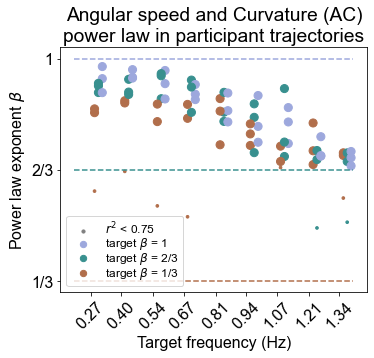

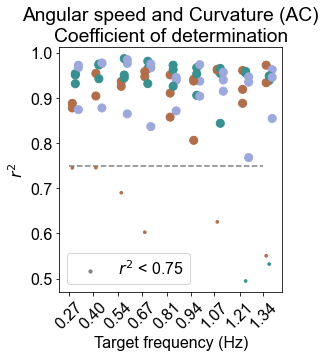

In [10]:

import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 16}

matplotlib.rc('font', **font)

freqs_t  = [d["freq"] + d["target"].betaCA * 0.05 for d in data]

betas  = [d["cursor"].betaCA for d in data]
r2s    = [d["cursor"].r2CA   for d in data]

beta_colors = ["#9da8dd", "#38908f", "#b16e4B"]


tb     = [0 if "beta1.0" in d["filename"] else 1 if "beta0.6" in d["filename"] else 2 for d in data]
clrs     = [beta_colors[tb[i]] for i in range(len(r2s))]
sizes    = [65 if r2 >= 0.75 else 7 for r2 in r2s]

plt.figure(figsize=(5.5, 4.5))

plt.plot([0.2, 1.4], [1, 1], "--", color=beta_colors[0])
plt.plot([0.2, 1.4], [2/3, 2/3], "--", color=beta_colors[1])
plt.plot([0.2, 1.4], [1/3, 1/3], "--", color=beta_colors[2])

plt.yticks([1/3, 2/3, 1], ["1/3", "2/3", "1"])

plt.scatter(freqs_t, betas, c = clrs, s=sizes)

plt.scatter([], [], c = "gray", s=10, label=r"$r^2$ < 0.75")
plt.scatter([], [], c = beta_colors[0], s=40, label=r"target $\beta$ = 1")
plt.scatter([], [], c =  beta_colors[1], s=40, label=r"target $\beta$ = 2/3")
plt.scatter([], [], c =  beta_colors[2], s=40, label=r"target $\beta$ = 1/3")


plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"Power law exponent $\beta$")

plt.xticks(freqs, rotation = 45)
plt.legend(loc = "lower left", prop={"size":12}, labelspacing=-0.1)
plt.title("Angular speed and Curvature (AC)\npower law in participant trajectories")
plt.savefig("..//figures//Appendix power law freq.pdf", format="pdf",  bbox_inches = "tight")
plt.show()

plt.figure(figsize=(4, 4.5))

plt.title("Angular speed and Curvature (AC)\nCoefficient of determination")
plt.plot([0.27, 1.34], [0.75, 0.75], "--", color="gray")
plt.scatter(freqs_t, r2s, c=clrs, s= sizes)
plt.scatter([], [], c = "gray", s=10, label=r"$r^2$ < 0.75")
plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"$r^2$")
plt.xticks(freqs, rotation = 45)
plt.legend()
plt.savefig("..//figures//Appendix power law Coefficient r2.pdf", format="pdf",  bbox_inches = "tight")
plt.show()
    

In [ ]:
## Appendix figures:

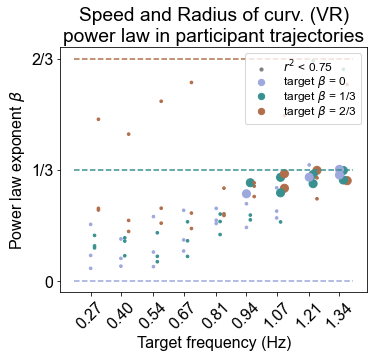

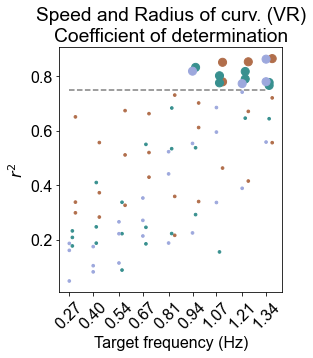

In [11]:
freqs_t  = [d["freq"] + d["target"].betaRV * 0.05 for d in data]

betas  = [d["cursor"].betaRV for d in data]
r2s    = [d["cursor"].r2RV   for d in data]

beta_colors = ["#9da8dd", "#38908f", "#b16e4B"]


tb     = [0 if "beta1.0" in d["filename"] else 1 if "beta0.6" in d["filename"] else 2 for d in data]
clrs     = [beta_colors[tb[i]] for i in range(len(r2s))]
sizes    = [65 if r2 >= 0.75 else 7 for r2 in r2s]

plt.figure(figsize=(5.5, 4.5))

plt.plot([0.2, 1.4], [0, 0], "--", color=beta_colors[0])
plt.plot([0.2, 1.4], [1/3, 1/3], "--", color=beta_colors[1])
plt.plot([0.2, 1.4], [2/3, 2/3], "--", color=beta_colors[2])

plt.yticks([0, 1/3, 2/3], ["0", "1/3", "2/3"])

plt.scatter(freqs_t, betas, c = clrs, s=sizes)

plt.scatter([], [], c = "gray", s=10, label=r"$r^2$ < 0.75")
plt.scatter([], [], c = beta_colors[0], s=40, label=r"target $\beta$ = 0")
plt.scatter([], [], c =  beta_colors[1], s=40, label=r"target $\beta$ = 1/3")
plt.scatter([], [], c =  beta_colors[2], s=40, label=r"target $\beta$ = 2/3")


plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"Power law exponent $\beta$")

plt.xticks(freqs, rotation = 45)
plt.legend(loc = "upper right", prop={"size":12}, labelspacing=-0.1)
plt.title("Speed and Radius of curv. (VR)\npower law in participant trajectories")
plt.savefig("..//figures//Appendix RcV freq_participant.pdf", format="pdf",  bbox_inches = "tight")
plt.show()

plt.figure(figsize=(4, 4.5))

plt.title("Speed and Radius of curv. (VR)\nCoefficient of determination")
plt.plot([0.27, 1.34], [0.75, 0.75], "--", color="gray")
plt.scatter(freqs_t, r2s, c=clrs, s= sizes)
plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"$r^2$")
plt.xticks(freqs, rotation = 45)
plt.savefig("..//figures//Appendix RcV Coefficient r2.pdf", format="pdf",  bbox_inches = "tight")
plt.show()

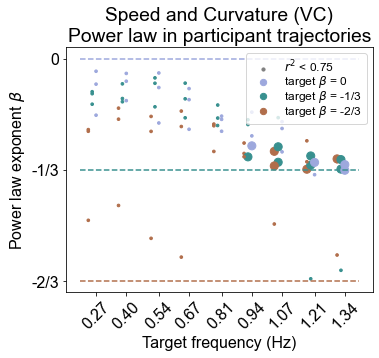

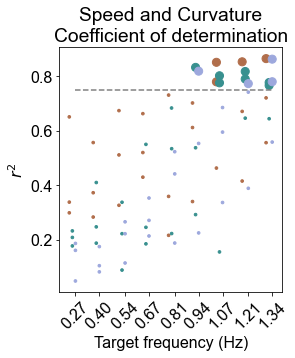

In [15]:
freqs_t  = [d["freq"] + d["target"].betaCV * 0.05 for d in data]

betas  = [d["cursor"].betaCV for d in data]
r2s    = [d["cursor"].r2CV   for d in data]

beta_colors = ["#9da8dd", "#38908f", "#b16e4B"]


tb     = [0 if "beta1.0" in d["filename"] else 1 if "beta0.6" in d["filename"] else 2 for d in data]
clrs     = [beta_colors[tb[i]] for i in range(len(r2s))]
sizes    = [65 if r2 >= 0.75 else 7 for r2 in r2s]


plt.figure(figsize=(5.5, 4.5))

plt.title("Speed and Curvature (VC)\nPower law in participant trajectories")

plt.plot([0.2, 1.4], [0, 0], "--", color=beta_colors[0])
plt.plot([0.2, 1.4], [-1/3, -1/3], "--", color=beta_colors[1])
plt.plot([0.2, 1.4], [-2/3, -2/3], "--", color=beta_colors[2])

plt.yticks([0, -1/3, -2/3], ["0", "-1/3", "-2/3"])

plt.scatter(freqs_t, betas, c = clrs, s=sizes)

plt.scatter([], [], c = "gray", s=10, label=r"$r^2$ < 0.75")
plt.scatter([], [], c = beta_colors[0], s=40, label=r"target $\beta$ = 0")
plt.scatter([], [], c =  beta_colors[1], s=40, label=r"target $\beta$ = -1/3")
plt.scatter([], [], c =  beta_colors[2], s=40, label=r"target $\beta$ = -2/3")


plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"Power law exponent $\beta$")

plt.xticks(freqs, rotation = 45)
plt.legend(loc = "upper right", prop={"size":12}, labelspacing=-0.1)
plt.savefig("..//figures//VC power law vs freq.pdf.pdf", format="pdf",  bbox_inches = "tight")
plt.show()

plt.figure(figsize=(4, 4.5))

plt.title("Speed and Curvature\n" + r"Coefficient of determination")
plt.plot([0.27, 1.34], [0.75, 0.75], "--", color="gray")
plt.scatter(freqs_t, r2s, c=clrs, s= sizes)
plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"$r^2$")
plt.xticks(freqs, rotation = 45)
plt.savefig("..//figures//VC power law vs freq Coefficient r2.pdf", format="pdf",  bbox_inches = "tight")
plt.show()